### imports

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import env
from utils import KaggleCameraDataset, progress_iter

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# training data
## load images (links)

In [29]:
train_data = KaggleCameraDataset('../data/', train=True, lazy=True)

## generate maximum number of non-overlapping patches from an image

In [12]:
def gen_patches(x, crop_size=64):
    """
    Parameters
    ----------
    x : (H, W, C) np.ndarray
    crop_size : positive int
    
    Returns
    -------
    patches : (D, `crop_size`, `crop_size`, C)
        where D = (H / `crop_size`)*(W / `crop_size`)
    """
    H, W, C = x.shape
    n_H = H / crop_size
    n_W = W / crop_size
    D = n_H * n_W
    patches = np.zeros((D, crop_size, crop_size, C), dtype=np.uint8)
    for i in xrange(n_H):
        for j in xrange(n_W):
            patches[i * n_W + j, ...] = x[i*crop_size:(i + 1)*crop_size, 
                                          j*crop_size:(j + 1)*crop_size, :]
    return patches

### check

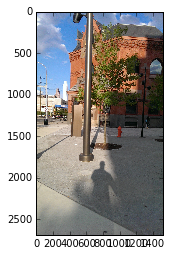

In [44]:
for x, _ in train_data:
    x = np.asarray(x, dtype=np.uint8)
    plt.imshow(x)
    break

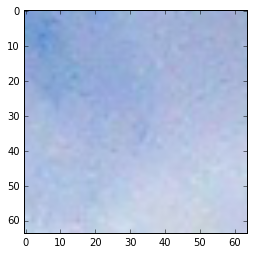

In [45]:
patches = gen_patches(x)
plt.imshow(Image.fromarray(patches[0]));

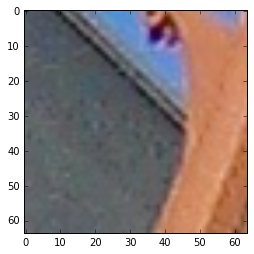

In [46]:
plt.imshow(Image.fromarray(patches[100]));

## function to compute patch score $Q(\mathbf{x})$

In [14]:
def Q(x, alpha=0.7, beta=4., gamma=np.log(0.01)):
    """
    Parameters
    ----------
    x : (H, W, C) np.ndarray
        [0; 1]-normalized image
    
    Returns
    -------
    Q : float
    """
    Q = []
    for c in xrange(x.shape[-1]):
        mu = np.mean(x[:, :, c])
        std = np.std(x[:, :, c])
        q = alpha * beta * mu * (1. - mu) + (1. - alpha) * (1. - np.exp(gamma * std))
        Q.append(q)
    return np.mean(Q)

### check

In [49]:
Q(patches[0]/255.)

0.56467943787766683

In [50]:
Q(patches[100]/255.)

0.82710393207960398

## carefully assemble most informative $K$ patches for each class
### for one class

In [112]:
def get_K_patches_for_class(c, K=12800, buf_size=2000, crop_size=64, threshold_Q=0.7):
    
    best_patches = np.zeros((K + buf_size, crop_size, crop_size, 3), dtype=np.uint8)
    best_Q_vals = np.zeros(K + buf_size)
    pos = 0

    X = [train_data.X[i] for i in xrange(len(train_data)) if train_data.y[i] == c]
    
    for x in progress_iter(X, verbose=True):    
        # gen patches and computes scores
        x = Image.open(x)
        x = np.asarray(x, dtype=np.uint8)
        patches = gen_patches(x)
        Q_vals = np.asarray([Q(p/255.) for p in patches])

        # filter out low-Q patches
        patches = patches[Q_vals > threshold_Q]
        Q_vals = Q_vals[Q_vals > threshold_Q]
        Q_vals = -Q_vals  # store -Q values for sort
        ind_local = Q_vals.argsort()
        patches = patches[ind_local[:buf_size]]
        Q_vals = Q_vals[ind_local[:buf_size]]
        n_current = len(Q_vals)

        # when pos < K, accumulators are not yet filled (with non-zeros)
        if pos < K:
            best_patches[pos:pos + n_current, ...] = patches
            best_Q_vals[pos:pos + n_current] = Q_vals
            pos += n_current
        # otherwise we add new values to the end (after K), and sort based on Q-values
        else:
            best_patches[K:K + n_current] = patches
            best_Q_vals[K:K + n_current] = Q_vals
            ind = best_Q_vals.argsort()
            best_patches = best_patches[ind]
            best_Q_vals = best_Q_vals[ind]

    if pos < K:
        print "Reduce threshold! There are only {0} patches out of {1}".format(pos, K)
    
    return best_patches[:K]

### for all classes

In [113]:
K = 12800
K_total = 10 * K
patches = np.zeros((K_total, 64, 64, 3), dtype=np.uint8)
for c in xrange(10):
    patches[c*K:(c + 1)*K] = get_K_patches_for_class(c, K=K)

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

In [119]:
patches.shape

(128000, 64, 64, 3)

In [11]:
np.save('../data/X_patches.npy', patches)

In [120]:
y = np.arange(10).repeat(K)
np.save('../data/y_patches.npy', y)

# test data
## load images (links)

In [9]:
test_data = KaggleCameraDataset('../data/', train=False, lazy=True)

## generate 16 most informative patches from images and use them for predictions

In [24]:
K = 16
test_patches = np.zeros((K * len(test_data), 64, 64, 3), dtype=np.uint8)

pos = 0
for x, _ in progress_iter(test_data, verbose=True): 
    x = np.asarray(x, dtype=np.uint8)
    patches = gen_patches(x)
    Q_vals = np.asarray([Q(p/255.) for p in patches])
    Q_vals = -Q_vals  # negate Q values for sort
    ind = Q_vals.argsort()
    patches = patches[ind[:K]]
    Q_vals = Q_vals[ind[:K]]
    test_patches[pos:pos + K] = patches

A Jupyter Widget

In [25]:
np.save('../data/X_test.npy', test_patches)